## Hiperparâmetros de treinamento

- **Iteração**: Consiste em um passo de otimização, com as seguintes etapas:

    - Opera a entrada na rede;
    - Cálculo da função de perda;
    - Cálculo do gradiente;
    - Atualização dos pesos;
    - Repete.

- **Batch**: Quantidade de amostras de dados vista em uma iteração.

     - O tamanho do batch interfere no comportamento de convergência. Mais amostras então menos iterações? Talvez. Porém com mais amostras, uma iteração se torna mais lenta. Então existe um trade off entre as duas coisas.

     - Por exemplo, se temos 3000 dados, separamos em 2000 de treino e 1000 de teste. Dos 2000 de treino podemos separar em 10 batches de 200 dados cada, dessa forma, precisaremos de 10 iterações para a rede ver todo o conjunto de treino. Essa quantidade de iterações necessárias para ver todos os dados de treino se chama de **Época**.

- **Época**: Uma Época é completada quando todas as amostras do conjunto de treino foram vistas pelo modelo.

    - MAS, se ao final de uma época, o modelo viu todas as amostras de treino, por que precisamos de mais de uma época? Isso se dá por conta do treinamento ser um processo iterativo, consistindo de pequenos ajustes. Vendo apenas uma vez todos os dados, a quantidade de iterações pode não ter sido suficiente para ajustar todos os pesos adequadamente.
    
    - A cada nova época, o modelo é mais refinado.

    - Em geral, os gráficos de convergência são definidos em termos das épocas. Loss X Epochs.


Dessa forma, o **fluxo de treinamento** é dado pelo seguinte loop:


    # Épocas
    for i in range(qtd_epocas):
        # Iterações
        for batch in dados_treino:
            # Forward
            ypred = net(batch)
            loss = criterion(ypred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()


In [30]:
# Imports
import torch
from torch import nn, optim

import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Dicionário de hiperparâmetros
args = {
    'batch_size' : 20,
    'qtd_processos' : 2,
    'lr' : 1e-4,
    'weight_decay' : 5e-4,
    'qtd_epocas' : 30
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

## Preparação dos dados

O pytorch oferece diversos datasets através de bibliotecas como o Torchtext e o Torchvision. Agora vamos usar o Torchvision, que é de imagens. Os textos exigem nuances adicionais.

Amostras de treino: 60000
Amostras de teste: 10000


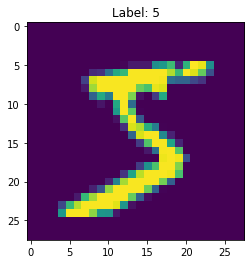

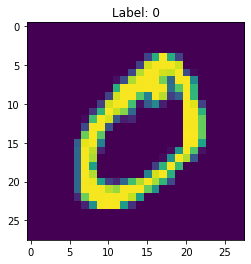

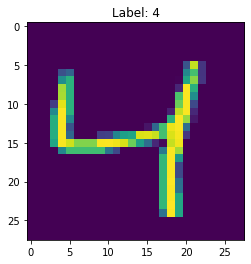

In [11]:
# Dados

from torchvision import datasets
from torchvision import transforms

# Dataset de números escritos à mão
dados_treino = datasets.MNIST('./', #root
                              train = True, 
                              transform = transforms.ToTensor(),  #transforma em tensor
                              download = True)

dados_teste = datasets.MNIST('./', 
                              train = False, 
                              transform = transforms.ToTensor(), 
                              download = False)

print("Amostras de treino:", len(dados_treino))
print("Amostras de teste:", len(dados_teste))

for i in range(3):
    dado, rotulo = dados_treino[i]

    plt.figure()
    plt.imshow(dado[0])
    plt.title('Label: ' + str(rotulo))

## Dataloader

O Dataloader irá fazer o gerenciamento dos dados para o treinamento da rede neural. Como a quantidade de dados é muito grande, precisamos desse gerenciamento para liberar espaço da memória. Além disso, o dataloader faz:

- Separação dos dados em batches;

- Embaralhamento dos dados;

- Carregar os batches em paralelo utilizando threads.

In [15]:
from torch.utils.data import DataLoader

loader_treino = DataLoader(dados_treino,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['qtd_processos'])

loader_teste = DataLoader(dados_teste,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['qtd_processos'])

torch.Size([20, 1, 28, 28]) torch.Size([20])


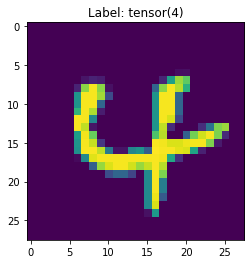

In [21]:
for batch in loader_treino:
    dado, rotulo = batch

    print(dado.size(), rotulo.size())

    plt.imshow(dado[0][0])
    plt.title('Label: ' + str(rotulo[0]))

    break

# Temos 20 amostras de dado com:
#   - 1 Canal de cor
#   - Altura x largura: 28x28
# Temos 20 amostras de rotulo com:
#   - 1 dimensão (1, 2, 3 etc)

# Fluxo de treinamento:

Implementação com os dados do fluxo de treinamento. Relembrando os passos:

- Iterar nas épocas;
- Iterar nos batches;
- Cast dos dados no dispositivo de hardware;
- Forward na rede e cálculo da loss;
- Cálculo do gradiente e atualização dos pesos.

Ao final de cada época, é mostrada a média e desvio padrão das perdas de cada iteração.

### Definição da rede

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X):

        X = X.view(X.size(0), -1) # mantém a primeira dimensão e lineariza o resto

        feature = self.relu(self.hidden(X))
        output = self.softmax(self.out(feature))

        return output

input_size = 1*28*28 # dimensao da entrada (cor*altura*largura)
hidden_size = 128
output_size = 10 # número de classes, como sao dígitos de 0 a 9 temos 10

net = MLP(input_size, hidden_size, output_size)
net = net.to(args['device'])

### Definição da Perda e Otimizador

In [27]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr = args['lr'], weight_decay = args['weight_decay'])

### Fluxo

In [31]:
# Iterar nas épocas;
for epoca in range(args['qtd_epocas']):

    epoca_loss = []
    
    # Iterar nos batches;
    for batch in loader_treino:
        dado, label = batch

        # Cast dos dados no dispositivo de hardware;
        dado = dado.to(args['device'])
        label = label.to(args['device'])

        # Forward na rede e cálculo da loss;
        pred = net(dado)
        loss = criterion(pred, label)

        epoca_loss.append(loss.cpu().data)

        # Cálculo do gradiente e atualização dos pesos (backpropagation)
        loss.backward()
        optimizer.step()

    epoca_loss = np.asarray(epoca_loss)
    print("Época %d, Loss: %.4f +/- %.4f" % (epoca+1, epoca_loss.mean(), epoca_loss.std()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Época 1, Loss: 1.6267 +/- 0.0829
Época 2, Loss: 1.6253 +/- 0.0819
Época 3, Loss: 1.6231 +/- 0.0830
Época 4, Loss: 1.6189 +/- 0.0815
Época 5, Loss: 1.6252 +/- 0.0840
Época 6, Loss: 1.6276 +/- 0.0822
Época 7, Loss: 1.6356 +/- 0.0841
Época 8, Loss: 1.6351 +/- 0.0852
Época 9, Loss: 1.6373 +/- 0.0857
Época 10, Loss: 1.6503 +/- 0.0874
Época 11, Loss: 1.6444 +/- 0.0867
Época 12, Loss: 1.6647 +/- 0.0907
Época 13, Loss: 1.6517 +/- 0.0863
Época 14, Loss: 1.6557 +/- 0.0889
Época 15, Loss: 1.6735 +/- 0.0914
Época 16, Loss: 1.6692 +/- 0.0919
Época 17, Loss: 1.6636 +/- 0.0895
Época 18, Loss: 1.6549 +/- 0.0901
Época 19, Loss: 1.6429 +/- 0.0841
Época 20, Loss: 1.6524 +/- 0.0876
Época 21, Loss: 1.6626 +/- 0.0907
Época 22, Loss: 1.6611 +/- 0.0877
Época 23, Loss: 1.6546 +/- 0.0890
Época 24, Loss: 1.6557 +/- 0.0912
Época 25, Loss: 1.6561 +/- 0.0895
Época 26, Loss: 1.6629 +/- 0.0902
Época 27, Loss: 1.6753 +/- 0.0906
Época 28, Loss: 1.6894 +/- 0.0942
Época 29, Loss: 1.7012 +/- 0.0952
Época 30, Loss: 1.7033 